Импорт библиотек

In [51]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [1]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/data_science/datasets/"

Mounted at /content/drive


In [ ]:
df = pd.read_csv(way + 'fish_train.csv')
df = df.head(119)
df.head(5)

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Roach,150.0,20.4,22.0,24.7,5.8045,3.7544
1,Perch,250.0,25.4,27.5,28.9,7.2828,4.5662
2,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
3,Bream,925.0,36.2,39.5,45.3,18.7542,6.7497
4,Perch,110.0,19.0,21.0,22.5,5.6925,3.5550


Всего датасет содержит 159 записей. Мы предварительно зарезервировали часть датасета для задания по преодолению бейслайна (baseline). В настоящем задании подразумевается работа с датасетом, содержащим 119 записей.

# 0. Применение полиномиальной регрессии для предсказания непрерывного параметра

Представленный набор данных — это набор данных о семи различных типах рыб, продаваемых в некоторой рыбной лавке. Наша цель заключается в том, чтобы предсказать массу рыбы по каким-то косвенным признакам, известным о рыбе. Сами признаки, быть может, нужно синтезировать из тех, что известны.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки с параметрами, указанными в вашем задании. Используйте стратификацию по колонке <code>Species</code>. Стратификация позволит сохранить доли представленных объектов (по представителям типов рыб) в тренировочной и тестовой выборках.

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=21, stratify=df['Species'])
print(train_df.shape, test_df.shape)

(95, 7) (24, 7)


Вычислите выборочное среднее колонки <code>Width</code> полученной тренировочной выборки.

In [ ]:
train_df['Width'].mean()

4.485259999999999

# 1. Построение базовой модели

Избавьтесь от категориальных признаков и обучите модель линейной регрессии (<code>LinearRegression()</code>) на тренировочном наборе данных. Выполните предсказания для тестового набора данных. Оцените модель при помощи метрики <code>r2_score()</code>.

In [ ]:
train_df = train_df.drop('Species', axis = 1)
test_df = test_df.drop('Species', axis = 1)

In [ ]:
model = LinearRegression()

model.fit(train_df.drop("Weight", axis=1), train_df["Weight"])
pred_df = model.predict(test_df.drop("Weight", axis=1))
r2_score(test_df['Weight'], pred_df)

0.8934687881663089

# 2. Добавление предварительной обработки признаков.

## Использование PCA

При помощи, например, <code>sns.heatmap()</code>, постройте матрицу корреляций признаков тренировочного набора данных и определите тройку наиболее коррелированных между собой признаков.

<Axes: >

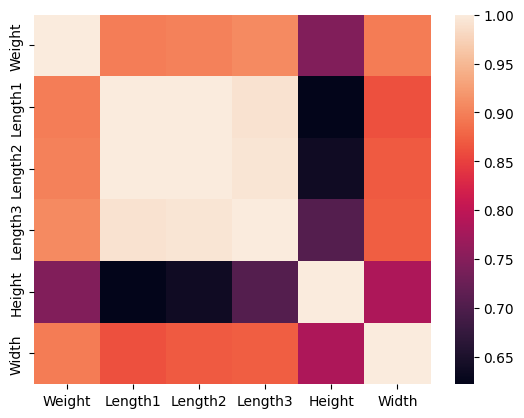

In [ ]:
df_cor = df.drop("Species", axis=1).corr()
sns.heatmap(df_cor)

Линейные модели достаточно плохо реагируют на коррелированные признаки, поэтому от таких признаков имеет смысл избавиться еще до начала обучения.

Для уменьшения количества неинформативных измерений используйте метод главных компонент. 

1) Примените метод главных компонент (<code>PCA(n_components=3, svd_solver='full')</code>) для трех найденных наиболее коррелированных признаков. 

2) Вычислите долю объясненной дисперсии при использовании только первой главной компоненты. 

3) Замените три наиболее коррелированных признака на новый признак <code>Lengths</code>, значения которого совпадают со значениями счетов первой главной компоненты.

In [ ]:
pca = PCA(n_components=3, svd_solver='full')
selected_columns = df[['Length1', 'Length2', 'Length3']]
pca.fit(selected_columns)
transformed_length = pca.transform(selected_columns)
df['Length'] = pd.Series(transformed_length[: , 0]).values
df = df.drop(['Length1', 'Length2', 'Length3'], axis=1)
df

,Species,Weight,Height,Width,Length
0,Roach,150.0,5.8045,3.7544,-11.486348
1,Perch,250.0,7.2828,4.5662,-3.048526
2,Bream,430.0,12.4440,5.1340,1.557884
3,Bream,925.0,18.7542,6.7497,19.779440
4,Perch,110.0,5.6925,3.5550,-14.171988
...,...,...,...,...,...
114,Parkki,273.0,11.0880,4.1440,-6.327814
115,Pike,500.0,6.9600,4.8960,27.717784
116,Whitefish,1000.0,12.3540,6.5250,19.542476
117,Perch,120.0,6.1100,3.4075,-12.442929


In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio[0]

0.9962761645834379

Примените полученное преобразование для тех же признаков в тестовом наборе данных. Обратите внимание, что заново обучать преобразование `PCA` не нужно. Аналогично предыдущему этапу замените три рассмотренных признака на один.

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=21, stratify=df['Species'])
train_df = train_df.drop('Species', axis = 1)
test_df = test_df.drop('Species', axis = 1)

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи <code>r2_score()</code>.

In [ ]:
model.fit(train_df.drop("Weight", axis=1), train_df["Weight"])
pred_df = model.predict(test_df.drop("Weight", axis=1))
r2_score(test_df['Weight'], pred_df)

0.8989521388173523

Видно, что точность значительно не изменилась.

## Модификация признаков

Постройте графики зависимостей признаков от целевой переменной, например, при помощи <code>sns.pairplot()</code>.

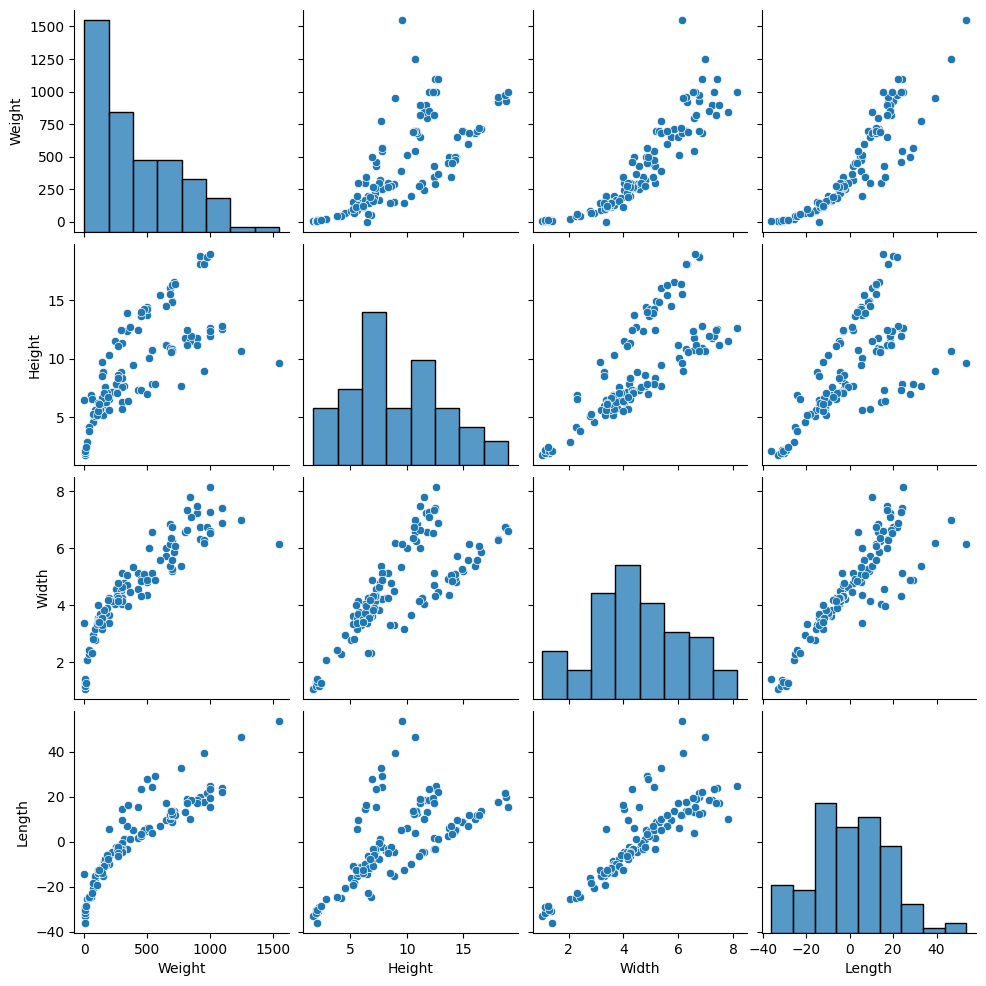

In [ ]:
sns.pairplot(df)

Видно, что масса, вообще говоря, нелинейно зависит от остальных параметров. Значит, чтобы линейная модель хорошо справлялась с предсказанием, признаки имеет смысл преобразовать так, чтобы зависимость стала более похожей на линейную. Но как придумать такую зависимость?

Логично предположить, что масса рыбы должна каким-то гладким образом зависеть от остальных параметров, отвечающих так или иначе за размеры. Если впомнить, что масса — это произведение плотности на объем, то

$$
m = \rho \cdot V.
$$

Допустим, что средняя плотность у всех рыб одинаковая, и вспомним, что при гомотетии объем объекта зависит от линейных размеров как куб, тогда получим

$$
m\sim V\sim d^3
$$

Все признаки тренировочного и тестового наборов данных, отвечающие так или иначе за размеры (<code>Height, Width, Lengths</code>), возведите в третью степень, и проверьте, стала ли зависимость массы от этих признаков похожа на линейную.

In [ ]:
selected_columns = df[['Height', 'Width', 'Length']]
selected_columns_cubed = selected_columns.applymap(lambda x: x**3)
df[['Height', 'Width', 'Length']] = selected_columns_cubed

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=21, stratify=df['Species'])
train_df = train_df.drop('Species', axis = 1)
test_df = test_df.drop('Species', axis = 1)
model.fit(train_df.drop("Weight", axis=1), train_df["Weight"])
pred_df = model.predict(test_df.drop("Weight", axis=1))
r2_score(test_df['Weight'], pred_df)

0.9392245307302994

Введите выборочное среднее колонки <code>Width</code> тренировочного набора данных после возведения в куб.

In [ ]:
train_df['Width'].mean()

126.73138191186727

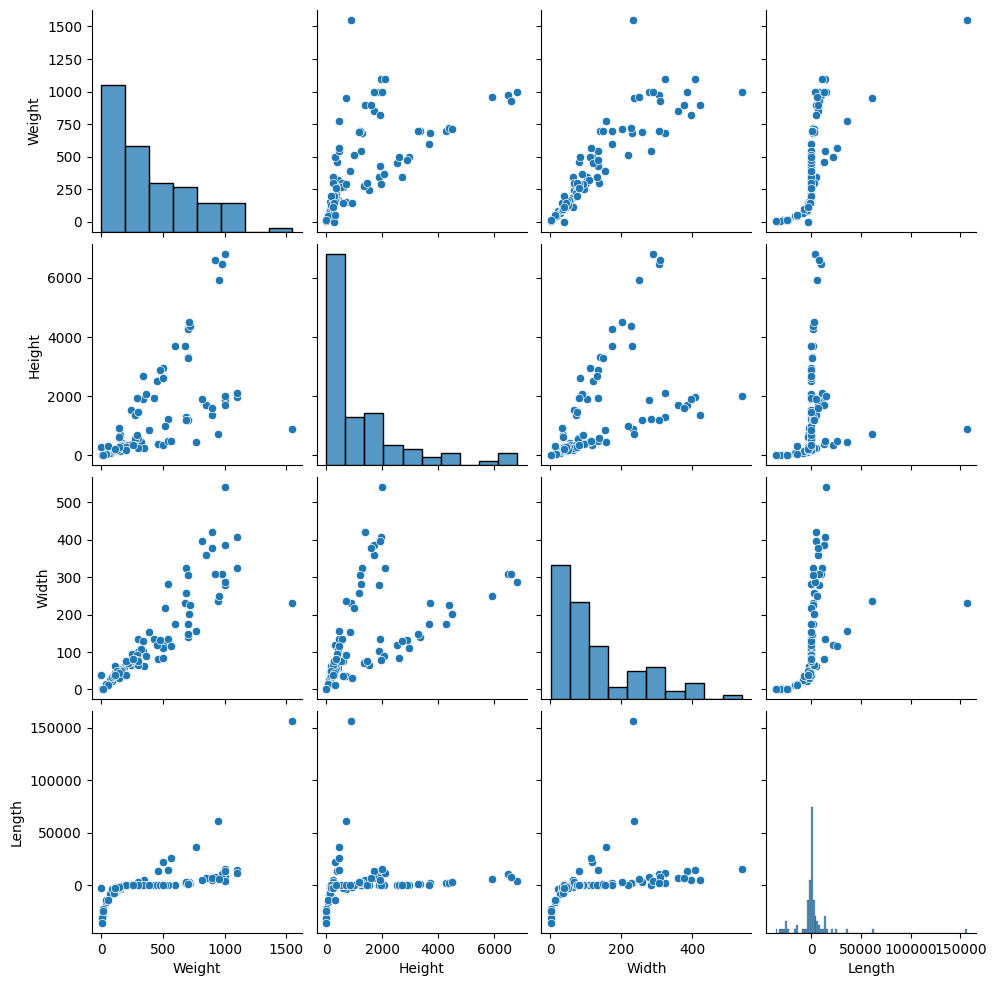

In [ ]:
sns.pairplot(train_df)

Выберите изображения, соответствующие зависимости <code>Weight</code> от <code>Width</code> до преобразования и после.

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи `r2_score()`.

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=21, stratify=df['Species'])
train_df = train_df.drop('Species', axis = 1)
test_df = test_df.drop('Species', axis = 1)
model.fit(train_df.drop("Weight", axis=1), train_df["Weight"])
pred_df = model.predict(test_df.drop("Weight", axis=1))
r2_score(test_df['Weight'], pred_df)

0.9392245307302994

Обратите внимание на то, как такая нехитрая работа с признаками помогла разительно улучшить точность модели!

## Добавление категориальных признаков

Произведите <code>one-hot</code> кодировние категориального признака `Species`, например, с помощью <code>pd.get_dummies()</code>.

Обучите модель линейной регресси на полученных тренировочных данных. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

<b>Примечание</b>: Мы специально использовали стратифицированное разделение, чтобы все значения категориального признака <code>Species</code> присутствовали во всех наборах данных. Но такое возможно не всегда. Про то, как с этим бороться можно почитать, [например, здесь](https://predictivehacks.com/?all-tips=how-to-deal-with-get_dummies-in-train-and-test-dataset).

In [ ]:
dummies = pd.get_dummies(df['Species'], prefix='Species')
df_dum = pd.concat([df, dummies], axis=1)
df_dum

,Species,Weight,Height,Width,Length,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,Roach,150.0,195.566492,52.920218,-1515.464970,0,0,0,0,1,0,0
1,Perch,250.0,386.273710,95.206103,-28.331510,0,0,1,0,0,0,0
2,Bream,430.0,1926.992424,135.321746,3.780985,1,0,0,0,0,0,0
3,Bream,925.0,6596.227555,307.505871,7738.235923,1,0,0,0,0,0,0
4,Perch,110.0,184.462936,44.928179,-2846.376115,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
114,Parkki,273.0,1363.200233,71.163818,-253.373508,0,1,0,0,0,0,0
115,Pike,500.0,337.153536,117.361115,21294.896091,0,0,0,1,0,0,0
116,Whitefish,1000.0,1885.483738,277.805953,7463.435167,0,0,0,0,0,0,1
117,Perch,120.0,228.099131,39.564674,-1926.494847,0,0,1,0,0,0,0


In [ ]:
train_df, test_df = train_test_split(df_dum, test_size=0.2, random_state=21, stratify=df['Species'])

In [ ]:
train_df, test_df = train_test_split(df_dum, test_size=0.2, random_state=21, stratify=df['Species'])
train_df = train_df.drop('Species', axis = 1)
test_df = test_df.drop('Species', axis = 1)

In [ ]:
model.fit(train_df.drop("Weight", axis=1), train_df["Weight"])
pred_df = model.predict(test_df.drop("Weight", axis=1))
r2_score(test_df['Weight'], pred_df)

0.9420735157746081

И снова точность возрасла.

Как можно увидеть, после `one-hot` кодирования признаки стали коррелированы. От этого можно избавиться, например, при помощи параметра `drop_first=True`. Заново обучите модель после исправления этого недочета. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

In [ ]:
dummies = pd.get_dummies(df['Species'], prefix='Species', drop_first=True)
df_dum = pd.concat([df, dummies], axis=1)
df_dum

In [ ]:
train_df, test_df = train_test_split(df_dum, test_size=0.2, random_state=21, stratify=df['Species'])
train_df = train_df.drop('Species', axis = 1)
test_df = test_df.drop('Species', axis = 1)
model.fit(train_df.drop("Weight", axis=1), train_df["Weight"])
pred_df = model.predict(test_df.drop("Weight", axis=1))
r2_score(test_df['Weight'], pred_df)

0.9420735157746081

На таком сравнительно небольшом наборе данных, впрочем, разницы мы не видим.

# Полный анализ

In [74]:
df_train2 = pd.read_csv(way + 'fish_train.csv')
df_test2 = pd.read_csv(way + 'fish_reserved.csv')

In [75]:
#pca = PCA(n_components=3, svd_solver='full')
selected_columns = ['Length1', 'Length2', 'Length3']
#pca.fit(selected_columns)
df_train2['length'] = df_train2[selected_columns].mean(axis=1)
df_train2 = df_train2.drop(selected_columns, axis=1)
df_train2.head(3)

,Species,Weight,Height,Width,length
0,Roach,150.0,5.8045,3.7544,22.366667
1,Perch,250.0,7.2828,4.5662,27.266667
2,Bream,430.0,12.4440,5.1340,29.833333


In [76]:
selected_columns = df_train2[['Height', 'Width', 'length']]
selected_columns_cubed = selected_columns.applymap(lambda x: x**3)
df_train2[['Height', 'Width', 'length']] = selected_columns_cubed

In [77]:
dummies = pd.get_dummies(df_train2['Species'], prefix='Species')
df_train2_dum = pd.concat([df_train2, dummies], axis=1)
df_train2_dum = df_train2_dum.drop('Species', axis = 1)
df_train2_dum.head(3)

,Weight,Height,Width,length,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,150.0,195.566492,52.920218,11189.322630,0,0,0,0,1,0,0
1,250.0,386.273710,95.206103,20271.978963,0,0,1,0,0,0,0
2,430.0,1926.992424,135.321746,26552.495370,1,0,0,0,0,0,0


Тестовая

In [78]:
#pca = PCA(n_components=3, svd_solver='full')
selected_columns = ['Length1', 'Length2', 'Length3']
#pca.fit(selected_columns)
df_test2['length'] = df_test2[selected_columns].mean(axis=1)
df_test2 = df_test2.drop(selected_columns, axis=1)
df_test2.head(5)

,Species,Height,Width,length
0,Roach,6.1146,3.2943,21.366667
1,Perch,6.3840,3.5340,21.133333
2,Perch,5.6358,3.0502,18.800000
3,Parkki,8.3922,2.9181,19.266667
4,Parkki,7.4052,2.6730,17.933333


In [79]:
selected_columns = df_test2[['Height', 'Width', 'length']]
selected_columns_cubed = selected_columns.applymap(lambda x: x**3)
df_test2[['Height', 'Width', 'length']] = selected_columns_cubed

In [80]:
dummies = pd.get_dummies(df_test2['Species'], prefix='Species')
df_test2_dum = pd.concat([df_test2, dummies], axis=1)
df_test2_dum = df_test2_dum.drop('Species', axis = 1)
df_test2_dum.head(5)

,Height,Width,length,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,228.614702,35.751102,9754.619296,0,0,0,0,1,0,0
1,260.182831,44.136677,9438.522370,0,0,1,0,0,0,0
2,179.005641,28.378207,6644.672000,0,0,1,0,0,0,0
3,591.054429,24.848519,7151.872296,0,1,0,0,0,0,0
4,406.078856,19.098395,5767.439704,0,1,0,0,0,0,0


In [81]:
scaler = StandardScaler()
df_train2_dum[['Height', 'Width', 'length']] = scaler.fit_transform(df_train2_dum[['Height', 'Width', 'length']])
df_test2_dum[['Height', 'Width', 'length']] = scaler.transform(df_test2_dum[['Height', 'Width', 'length']])

In [82]:
model = LinearRegression()
model.fit(df_train2_dum.drop("Weight", axis=1), df_train2_dum["Weight"])
pred_df = model.predict(df_test2_dum)
pred_df

array([ 109.20921006,  139.89471177,  103.03173688,  117.93835881,
         94.74637261,  178.78985383,   73.85991981,  472.94233234,
        404.58067584,  110.82096852, 1945.5101298 ,  182.30433818,
        624.42211128, 1077.96798847,   50.82926741,  619.16774777,
        126.00515732,  799.40740631, 1496.59581375,  104.62028861,
        591.01712472,  178.68319311,  100.07903469,  176.92585199,
        260.13958458,  586.66795634,  369.12292749,   11.86054991,
         25.7079947 ,    6.51206736,  995.56430625,  478.50172991,
        540.34301462,  156.94899514,   13.04760117,   78.58415817,
        142.77278137,  919.90972142,  739.92598912,  150.97561481])

In [84]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0) # alpha - параметр регуляризации
ridge_model.fit(df_train2_dum.drop("Weight", axis=1), df_train2_dum["Weight"])
pred_df = ridge_model.predict(df_test2_dum)
pred_df

array([ 109.61496624,  140.12933074,  103.34366808,  116.81921301,
         93.55189656,  178.03376111,   74.42895876,  483.20851372,
        402.04162283,  112.37406947, 1905.75757868,  180.56128175,
        622.89911825, 1073.63216847,   51.38923062,  616.1956967 ,
        125.70270423,  800.92028826, 1461.27997063,  104.58242818,
        588.7862607 ,  179.63709213,  100.65261835,  176.21242082,
        282.99211621,  588.26977073,  353.91341152,   13.04608513,
         26.55673549,    7.87749914,  990.0507558 ,  480.35615379,
        539.48293011,  156.2376279 ,   14.08197506,   79.3333135 ,
        142.51385402,  922.71899319,  741.21760362,  150.6405789 ])